This notebook solves the kernel SVM with CVXOPT

In [8]:
import numpy as np
import math
import cvxopt as cvx
import pickle
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt
import seaborn as sns
% matplotlib inline

In [9]:
X_mat = pd.read_csv('data/building_level_data.csv').as_matrix()

filename_y_vec = 'data/y_vec_full_adj_Dec-23-2018.txt'
with open(filename_y_vec, 'r') as f:
    lines = [el.rstrip()[-1] for el in f.readlines()]
    y_vec = np.array([float(el) for el in lines if el != '"'])
    f.close()


print X_mat.shape
print y_vec.shape

(39, 14)
(39,)


### Solve the SVM with CVXOPT

In [10]:
def rbf_kernel_function(x1, x2, gamma_param):
    return math.exp(-gamma_param*np.dot(x1-x2, x1-x2))

def create_Gram_matrix_RBF(X_mat, gamma_param=500):
    '''
    I am going to assume that in X_mat the samples are on the rows and the features on the columns
    '''
    
    n_samples = X_mat.shape[0]
    out_mat = np.ones((n_samples, n_samples))
    
    for ii in range(n_samples):
        for jj in range(ii+1, n_samples):
            out_mat[ii, jj] = rbf_kernel_function(X_mat[ii,:], X_mat[jj,:], gamma_param=gamma_param)
            out_mat[jj, ii] = out_mat[ii, jj]
    
    return out_mat

def kernel_building(filename='data/gram_mat_full_adj_Dec-23-2018.csv'):
    kern_mat = pd.read_csv(filename).set_index('Unnamed: 0').as_matrix()
    return kern_mat
    
kern_mat_temp = kernel_building()
print kern_mat_temp.shape

(39, 39)


In [11]:
## Account for cases in which we have -1 (Kernel Singular Matrix) or 0 (Graph too big) in the columns of the Kernel.
## Either the matrix was invertible or we did not have enough computing power

indices = []
for row in range(X_mat.shape[0]):
    if sum(kern_mat_temp[row, :]) == -1*X_mat.shape[0]:
        print row
        indices.append(row)
    if len(np.where(kern_mat_temp[row, :] == 0)[0]) > 0:
        print 'Removing row:', row
        indices.append(row)

indices_sel = [el for el in range(X_mat.shape[0]) if el not in indices]
X_mat = X_mat[indices_sel, :]
y_vec = y_vec[indices_sel]
kern_mat_temp = kern_mat_temp[indices_sel, :]
kern_mat_temp = kern_mat_temp[:, indices_sel]

21


In [14]:
print 'X matrix shape:', X_mat.shape
print 'Y vector shape:', y_vec.shape
print 'Proportion of Mosques:', 1 - np.mean(y_vec)

X matrix shape: (38, 14)
Y vector shape: (38,)
Proportion of Mosques: 0.5


In [15]:
def fit(x, y, K_mat): 
    NUM = x.shape[0]

    P = cvx.matrix(K_mat)
    q = cvx.matrix(-np.ones((NUM, 1)))
    
    G = cvx.matrix(-np.eye(NUM))
    h = cvx.matrix(np.zeros(NUM))
    
    A = cvx.matrix(y.reshape(1, -1))
    b = cvx.matrix(np.zeros(1))
    
    cvx.solvers.options['show_progress'] = False
    sol = cvx.solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

w_vec = fit(X_mat, y_vec, K_mat=kern_mat_temp)

In [18]:
## Printing Indices of the Smallest Values

for value in np.sort(np.abs(w_vec).reshape((-1,)))[::-1]:
    print 'Solution Value:', value, 'Index:',np.where(np.abs(w_vec) == value)[0][0]

Solution Value: 0.03576589404478037 Index: 22
Solution Value: 1.9536205616973615e-09 Index: 31
Solution Value: 3.583825416975257e-11 Index: 23
Solution Value: 2.1773340849819527e-11 Index: 17
Solution Value: 2.026576646308423e-11 Index: 24
Solution Value: 1.6786955003336883e-11 Index: 29
Solution Value: 1.6164251631213425e-11 Index: 14
Solution Value: 1.4020068095559064e-11 Index: 27
Solution Value: 1.1081880092274132e-11 Index: 33
Solution Value: 7.0840566356488095e-12 Index: 34
Solution Value: 5.233738750741477e-12 Index: 26
Solution Value: 5.12601123078532e-12 Index: 28
Solution Value: 4.924507438250783e-12 Index: 20
Solution Value: 4.540709547914231e-12 Index: 12
Solution Value: 4.322663181271037e-12 Index: 2
Solution Value: 3.670763619064003e-12 Index: 11
Solution Value: 3.645001644703848e-12 Index: 7
Solution Value: 3.511888770477718e-12 Index: 1
Solution Value: 2.63426497760181e-12 Index: 6
Solution Value: 2.5131436803123535e-12 Index: 0
Solution Value: 2.4621917679780083e-12 In

In [20]:
from sklearn.metrics import accuracy_score

def calculate_optimal_parameters(X_mat, y_mat, solution, gram_mat=kern_mat_temp, sol_thresh=1e-5):
    idx_alpha_not_zero = np.where(np.abs(solution) > sol_thresh)[0]
    beta0 = []
    for idx in idx_alpha_not_zero:
        beta0_temp = 0
        for i in range(solution.shape[0]):
            beta0_temp += solution[i]*y_mat[i]*gram_mat[i, idx]
        beta0.append(y_mat[idx] - beta0_temp)

    return np.mean(beta0)

beta_0 = calculate_optimal_parameters(X_mat=X_mat, y_mat=y_vec, solution=w_vec)

In [24]:
### LOOCV Calculation

def loocv_SVM(X, y, kern_mat, sol_thresh=1e-5):
    
    y_predicted = []
    y_true = []
    n = X.shape[0]
    
    for row in range(n):
        indices_temp = [el for el in range(n) if el != row]
        
        X_mat = X[indices_temp, :]
        y_vec = y[indices_temp]
        kern_mat_temp = kern_mat[indices_temp, :]
        kern_mat_temp = kern_mat_temp[:, indices_temp]
        
        w_vec = fit(X_mat, y_vec, K_mat=kern_mat_temp)
        beta_0 = calculate_optimal_parameters(X_mat=X_mat, y_mat=y_vec, solution=w_vec, sol_thresh=sol_thresh)

        y_pred = 0
        for i in range(w_vec.shape[0]):
            y_pred += w_vec[i]*y_vec[i]*kern_mat[row, i]
        y_pred += beta_0
        
        y_predicted.append(1 if np.sign(y_pred) == 1 else 0)
        y_true.append(y[row])
    
    return y_predicted, y_true
        
y_predicted_loocv, y_true_loocv = loocv_SVM(X=X_mat, y=y_vec, kern_mat=kern_mat_temp, sol_thresh=1e-5)
print 'Predicted:', y_predicted_loocv
print 'Actual:', map(int, y_true_loocv)
print 'Classification accuracy:', (accuracy_score(y_true_loocv, y_predicted_loocv))*100

Predicted: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Actual: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Classification accuracy: 94.73684210526315


## Let's plot the graph mis-classified

In [20]:
full_dict = pickle.load(open('processed_dict/graph_dict_flnms_dfs_adjmats.pkl', 'rb'))
dataframe_dict = full_dict['dataframe']

dataframe_list = []
name_list = []
for bld_name in ['Monasteries', 'Mosques']:
    for i in range(len(dataframe_dict[bld_name])):
        dataframe_list.append(dataframe_dict[bld_name][i])
        name_list.append(full_dict['filename'][bld_name][i])
        
dataframe_list_pruned = [el for j, el in enumerate(dataframe_list) if j in indices_sel]
name_list_pruned = [el for j, el in enumerate(name_list) if j in indices_sel]

In [21]:
def return_graph(df):
    
    G=nx.Graph()
    df['nconn'] = df['connectivity'].apply(lambda x: len(x))
    node_list = range(len(df['index'].values))
    G.add_nodes_from(node_list)

    sublist_connectivity = df['connectivity']
    list_connectivity = [el for sublist in sublist_connectivity for el in sublist]
    G.add_edges_from(list_connectivity)

    return G

correct_predictions = [index for index, pred in enumerate(y_predicted_loocv) if pred == y_true_loocv[index]]
wrong_predictions = [index for index, pred in enumerate(y_predicted_loocv) if pred != y_true_loocv[index]]

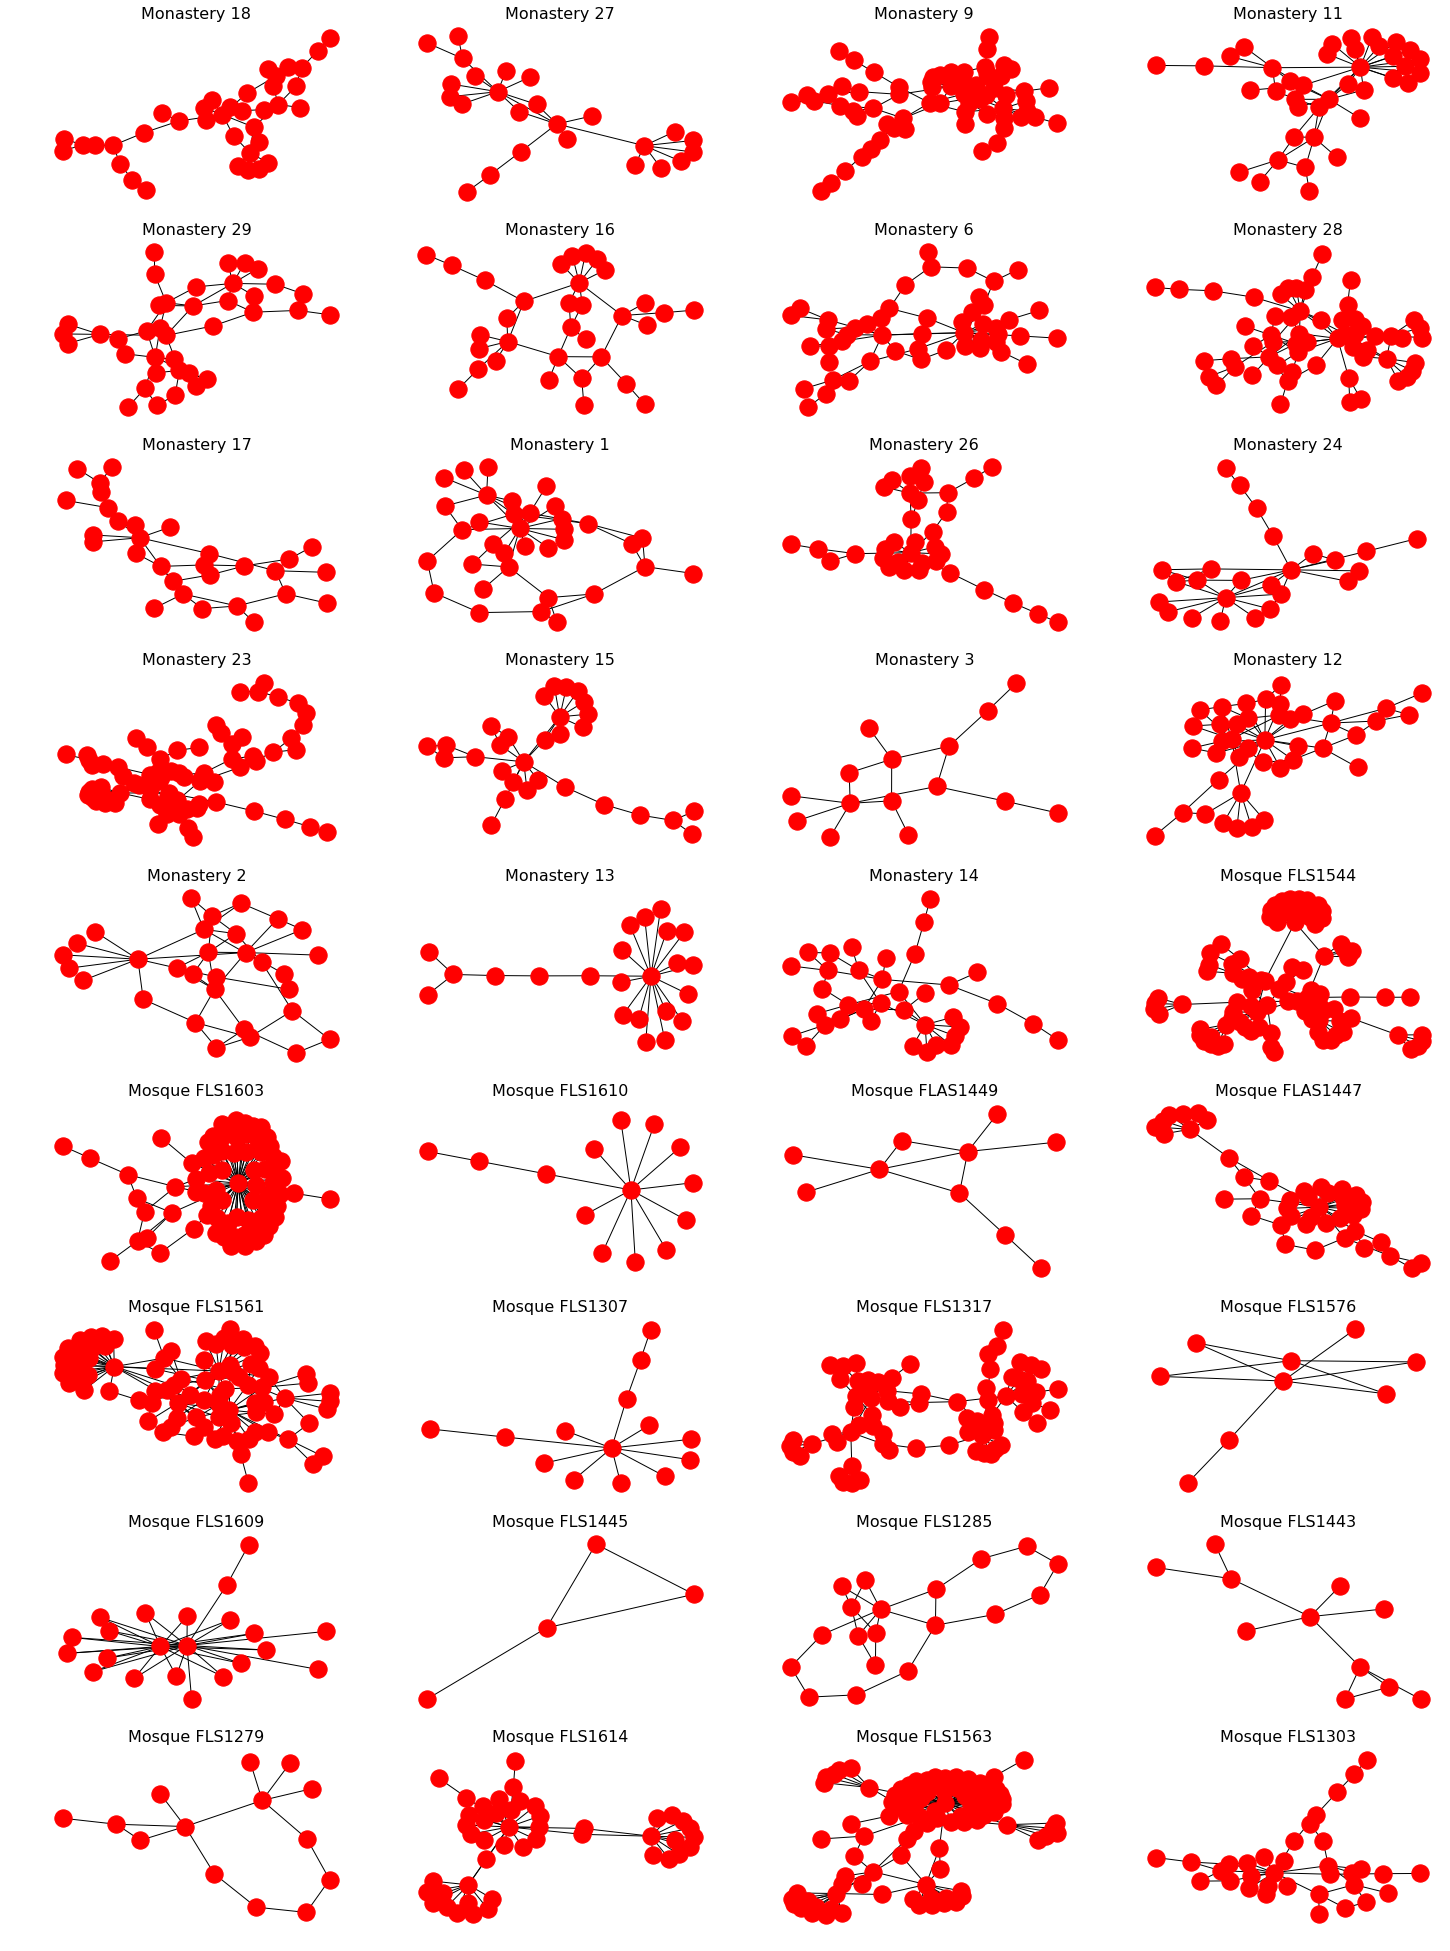

In [78]:
plt.rcParams['figure.figsize'] = 25, 35

number_of_columns = 4
number_of_rows = (len(correct_predictions) / number_of_columns)
indices_plot = [((index / number_of_columns) + 1, (index % number_of_columns)+1)  for index, _ in enumerate(correct_predictions)]
number_of_subplots = len(correct_predictions)

plt_index = 1
for j,df in enumerate(dataframe_list_pruned):
    if j in correct_predictions:
        G = return_graph(df)
        ax1 = plt.subplot(number_of_rows, number_of_columns, plt_index)
        plt_index += 1
        nx.draw(G)
        if j <= 18:
            ax1.set_title('Monastery ' + name_list_pruned[j].split('/')[-1].replace('.txt', ''), fontsize=16)
        else:
            ax1.set_title('Mosque ' + name_list_pruned[j].split('/')[-1].replace('.txt', ''), fontsize=16)
plt.savefig('images/correct_predictions_graphs.png', dpi=200)
plt.show()

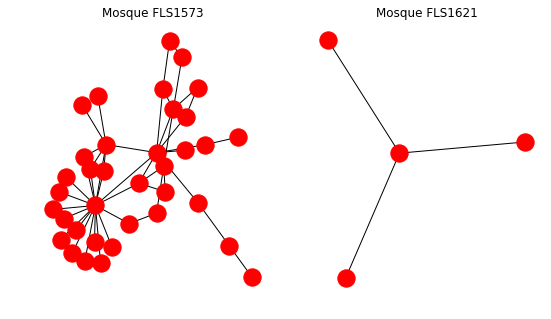

In [57]:
plt.rcParams['figure.figsize'] = 9, 5

number_of_columns = 2
number_of_rows = (len(wrong_predictions) / number_of_columns)
indices_plot = [((index / number_of_columns) + 1, (index % number_of_columns)+1)  for index, _ in enumerate(wrong_predictions)]
number_of_subplots = len(wrong_predictions)

fig = plt.figure(1)
plt_index = 1
for j,df in enumerate(dataframe_list_pruned):
    if j in wrong_predictions:
        G = return_graph(df)
        ax1 = plt.subplot(number_of_rows, number_of_columns, plt_index)
        plt_index += 1
        nx.draw(G)
        if j <= 18:
            ax1.set_title('Monastery ' + name_list_pruned[j].split('/')[-1].replace('.txt', ''))
        else:
            ax1.set_title('Mosque ' + name_list_pruned[j].split('/')[-1].replace('.txt', ''))
plt.savefig('images/wrong_predictions_graph.png', dpi=600)
plt.show()

## Plot the closest point to boundary

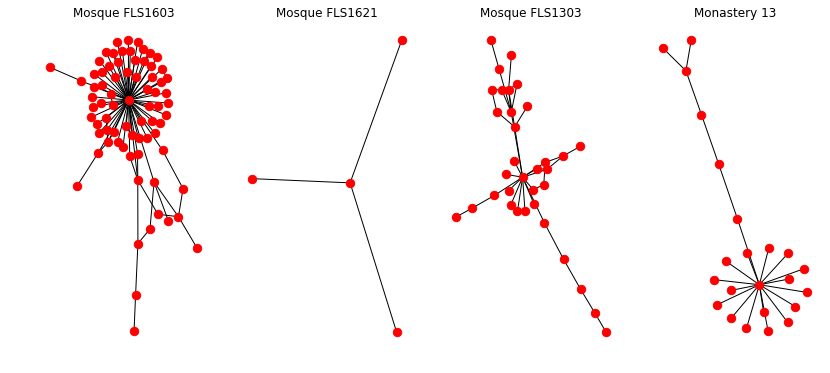

In [85]:
indices_sv = [21, 22, 37, 17]
plt.rcParams['figure.figsize'] = 14, 6

number_of_columns = 4
number_of_rows = (len(indices_sv) / number_of_columns)
number_of_subplots = len(indices_sv)

for j, idx in enumerate(indices_sv):
    df = dataframe_list_pruned[idx]
    G = return_graph(df)
    ax1 = plt.subplot(number_of_rows, number_of_columns, j+1)
    #nx.draw_networkx(G, node_size=150)
    nx.draw(G, node_size=70)
    if idx <= 18:
        ax1.set_title('Monastery ' + name_list_pruned[idx].split('/')[-1].replace('.txt', ''))
    else:
        ax1.set_title('Mosque ' + name_list_pruned[idx].split('/')[-1].replace('.txt', ''))
plt.savefig('images/closest_points_boundary.png', dpi=500)
plt.show()